In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

from session.sessions import selected_009266, selected_009265
from loading import load_session_data
from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
import pandas as pd
from aeps import AEP_metrics_lims
from population import unit_response_matrix, activity_at_phase
from sklearn import decomposition

%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Background / Target

In [4]:
# Miguel 60
source = '/home/sobolev/nevermind/AG_Pecka/data/processed'
animal = '60'
sessions = []
for folder in os.listdir(os.path.join(source, animal)):
    if os.path.exists(os.path.join(source, animal, folder, 'AEPs.h5')):
        sessions.append(folder)
sessions.sort()

idx_l, idx_r = 80, 120
selected = sessions[:2]

In [18]:
sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# 57
selected = [
    "57_SIT_2023-12-21_15-05-52",
    "57_SIT_2023-12-22_14-08-07",
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_16-38-05",
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-54-59",
]

selected = [
    "009266_hippoSIT_2023-04-20_08-57-39",
    "009266_hippoSIT_2023-04-20_15-24-14",
    "009266_hippoSIT_2023-04-26_08-20-17",
    "009266_hippoSIT_2023-05-04_19-47-15"
]

# special for 009265
#selected = selected[7:-1]
#selected = selected[:]

len(selected), selected

(4,
 ['009266_hippoSIT_2023-04-20_08-57-39',
  '009266_hippoSIT_2023-04-20_15-24-14',
  '009266_hippoSIT_2023-04-26_08-20-17',
  '009266_hippoSIT_2023-05-04_19-47-15'])

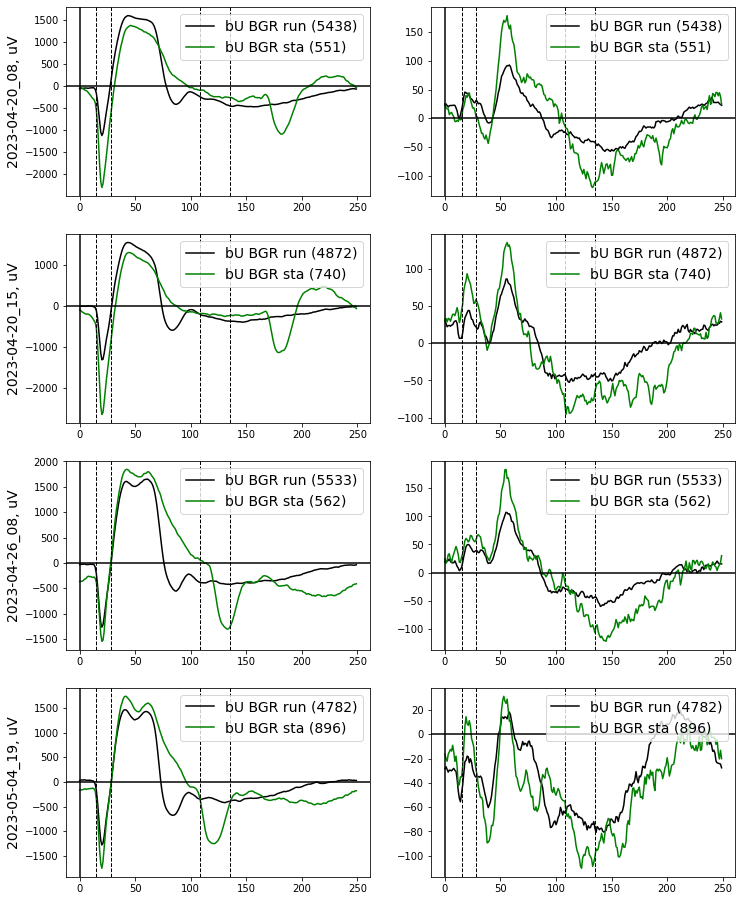

In [25]:
all_areas = ['A1', 'PPC']
cols = len(all_areas)
rows = len(selected)
speed_thresh = 0.04  # m/s

fig = plt.figure(figsize=(6*cols, 4*rows))

for i, session in enumerate(selected):
    animal     = session.split('_')[0]
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    aeps_file  = os.path.join(source, animal, session, 'AEPs.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    
    # getting AEPs
    aeps = {}
    with h5py.File(aeps_file, 'r') as f:
        for area in all_areas:
            if not area in f:
                continue
            ds_name = [ds for ds in f[area]][0]
            aeps[area] = np.array(f[area][ds_name])
    with h5py.File(meta_file, 'r') as f:
        events = np.array(f['processed']['sound_events'])
    #with h5py.File(desc_file, 'r') as f:
    #    speed = np.array(f['speed'])
    #with h5py.File(state_file, 'r') as f:
    #    idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bE state
    # print 3*std for info
    #print("A1: %.2f, PPC: %.2f" % (3*aeps['A1'].std(), 3*aeps['PPC'].std()))
    
    # auditory state (BGR, SIL etc.) and speed filter
    #idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    #idxs_run_ev = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]  # define speed filter here
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial
    
    # final separation
#     idxs_AL_bgr_ev  = np.intersect1d(idxs_AL_ev, idxs_bgr_ev)
#     idxs_AL_tgt_ev  = np.intersect1d(idxs_AL_ev, idxs_tgt_ev)
#     idxs_AL_sil_ev  = np.intersect1d(idxs_AL_ev, idxs_sil_ev)

#     idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
#     idxs_PH_bgr_ev = np.intersect1d(idxs_PH_ev, idxs_bgr_ev)
#     idxs_PH_sil_ev = np.intersect1d(idxs_PH_ev, idxs_sil_ev)

#     idxs_AL_bgr_rest_ev = np.intersect1d(idxs_AL_bgr_ev, idxs_sta_ev)
#     idxs_PH_bgr_rest_ev = np.intersect1d(idxs_PH_bgr_ev, idxs_sta_ev)
#     idxs_AL_sil_rest_ev = np.intersect1d(idxs_AL_sil_ev, idxs_sta_ev)
#     idxs_PH_sil_rest_ev = np.intersect1d(idxs_PH_sil_ev, idxs_sta_ev)
#     idxs_PH_bgr_run_ev  = np.intersect1d(idxs_PH_bgr_ev, idxs_run_ev)
    
    areas = list(aeps.keys())
    if 'A1' in areas:
        aeps['A1'][aeps['A1'] >  5000]   =   5000
        aeps['A1'][aeps['A1'] < -5000]   =  -5000
    if 'PPC' in areas:
        aeps['PPC'][aeps['PPC'] >  1500] =   1500
        aeps['PPC'][aeps['PPC'] < -1500] =  -1500
    
    # plotting
    # - AL vs PH in BGR
    # - AL vs PH in BGR (sta only)
    # - AL vs PH in SIL
    idxs_A = idxs_bgr_ev #idxs_PH_bgr_run_ev
    idxs_B = idxs_tgt_ev #idxs_PH_bgr_rest_ev
    labels = ['bU BGR run', 'bU BGR sta']
    for j, area in enumerate(areas):
        ax = fig.add_subplot(rows, cols, 2*i+1+j)
        aeps_bgr_mean = aeps[area][idxs_A].mean(axis=0)
        aeps_tgt_mean = aeps[area][idxs_B].mean(axis=0)
        
        ax.plot(aeps_bgr_mean, color='black', label="%s (%d)" % (labels[0], len(idxs_A)))
        ax.plot(aeps_tgt_mean, color='green', label="%s (%d)" % (labels[1], len(idxs_B)))
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.legend(loc='upper right', prop={'size': 14})
        if j == 0:
            ax.set_ylabel('%s, uV' % session[-19:-6], fontsize=14)

        # plot metric lims - A1 2/3
        #for m_name, lims in AEP_metrics_lims[area].items():
        #    ax.axvline(lims[0], color='black', ls='--')
        #ax.axvline(AEP_metrics_lims[area]['P3'][1], color='black', ls='--', lw=1)
        
        for val in [15, 28, 108, 135]:
            ax.axvline(val, color='black', ls='--', lw=1)
        
        
#fig.savefig(os.path.join(report, 'AEPs', animal, 'AEPs_avgs_%s_%s_%s.pdf' % (animal, str(idx_l), str(idx_r))))

In [ ]:
# LOOK AT RUNNING vs STATIONARY IN bU - in PPC! 
# Looks like in STA there is a 2-fold more signal!!

## Att state

In [9]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/reporting'

sessions = [s for s in selected_009266.keys()]
sessions.sort()
selected = sessions[:-5]
selected.remove('009266_hippoSIT_2023-04-20_15-24-14')  # only one A1 unit
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15']

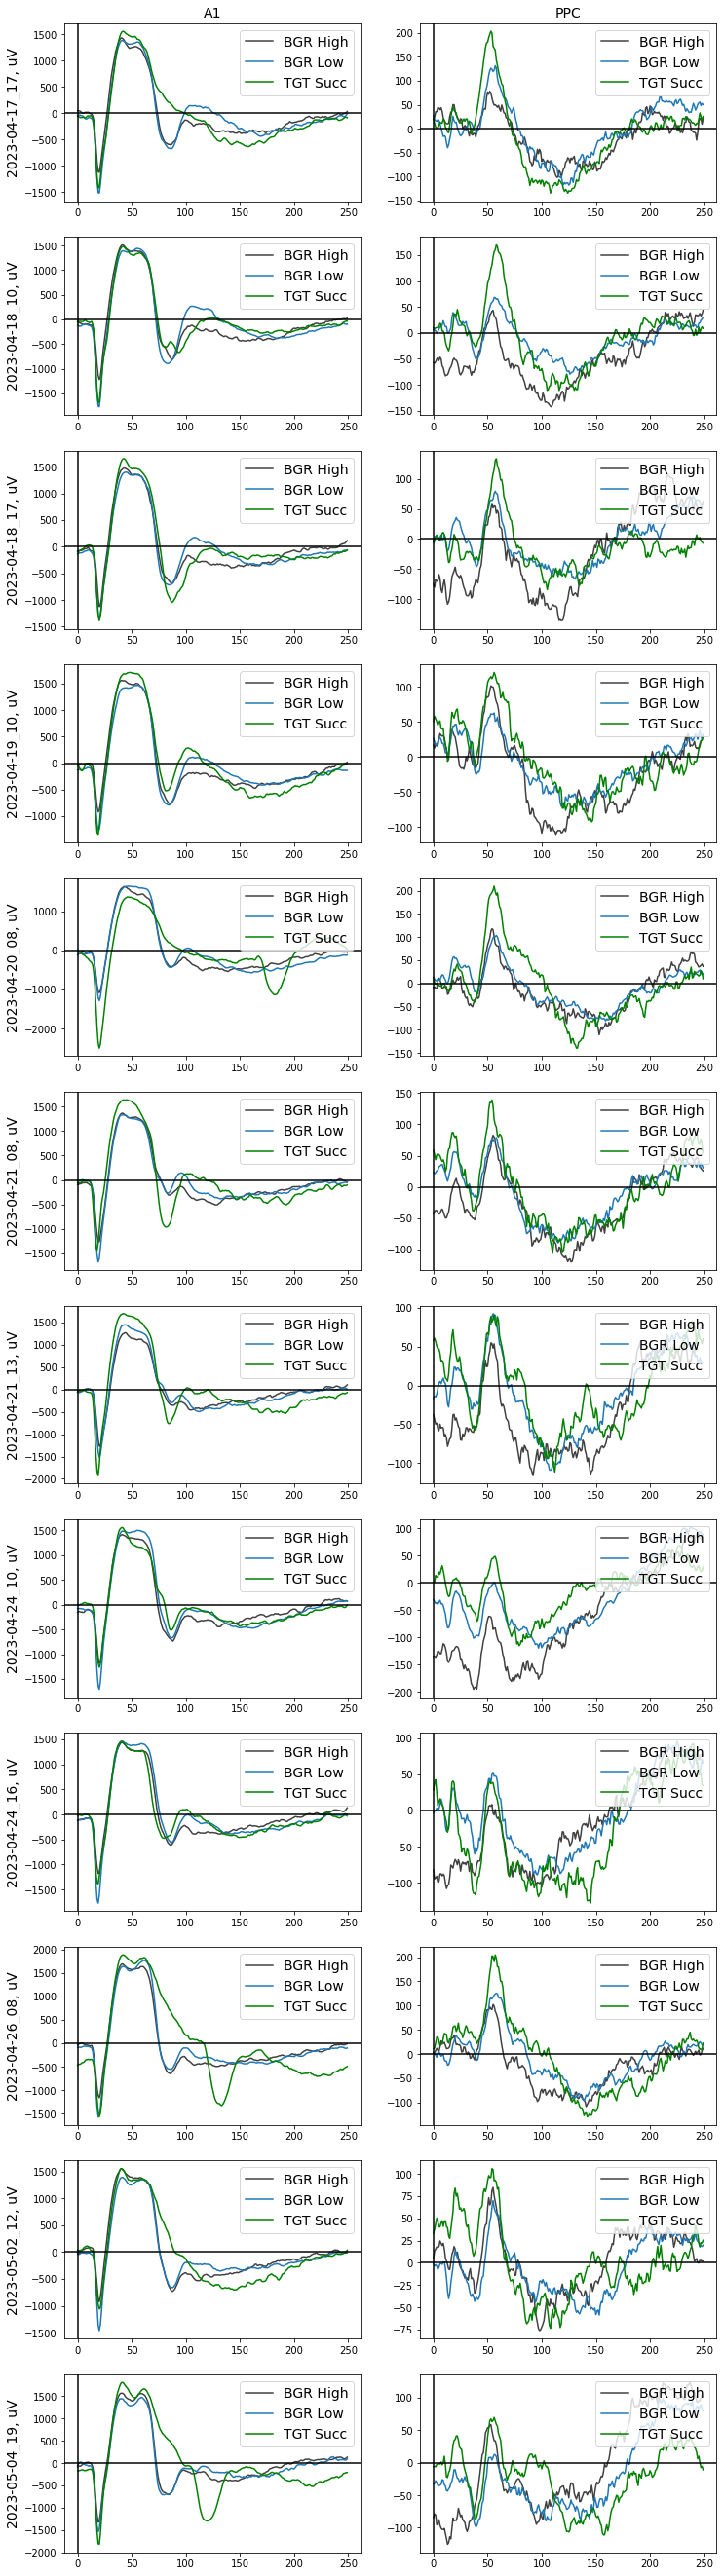

In [11]:
all_areas = ['A1', 'HPC']
cols = len(all_areas)
rows = len(sessions)

fig = plt.figure(figsize=(6*cols, 4*rows))

for i, session in enumerate(selected):
    animal       = session.split('_')[0]
    session_path = os.path.join(dst_path, animal, session)
    meta_file    = os.path.join(dst_path, animal, session, 'meta.h5')
    aeps_file    = os.path.join(dst_path, animal, session, 'AEPs.h5')

    # reading data
    with h5py.File(meta_file, 'r') as f:
        tl           = np.array(f['processed']['timeline'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
        sound_events = np.array(f['processed']['sound_events'])

    aeps = {}
    with h5py.File(aeps_file, 'r') as f:
        for area in f:
            aeps_name = [x for x in f[area]][0]
            aeps[area] = np.array(f[area][aeps_name])

    areas = list(aeps.keys())
    if 'A1' in areas:
        aeps['A1'][aeps['A1'] >  5000]   =   5000
        aeps['A1'][aeps['A1'] < -5000]   =  -5000
    if 'HPC' in areas:
        aeps['HPC'][aeps['HPC'] >  1500] =   1500
        aeps['HPC'][aeps['HPC'] < -1500] =  -1500
    if 'PPC' in areas:
        aeps['PPC'][aeps['PPC'] >  1500] =   1500
        aeps['PPC'][aeps['PPC'] < -1500] =  -1500

    # A1 unit response matrix (not z-scored)
    pop_response = spontaneous_activity(os.path.join(dst_path, animal, session))
    sos = signal.butter(10, 0.01, fs=4, analog=False, btype='highpass', output='sos')
    pop_response = signal.sosfiltfilt(sos, pop_response)
    
    # filter running states and compute sound states
    # target states (success / miss)
    idxs_se_succ = np.concatenate([np.arange(r[0] + 2, r[1]) for r in tgt_mx[tgt_mx[:, 4] == 1]]) # filter first 2 as MMR!
    idxs_se_miss = np.concatenate([np.arange(r[0], r[1]) for r in tgt_mx[tgt_mx[:, 4] == 0]])

    # attentional states
    idxs_pop_high = np.where(pop_response > pop_response.mean() + 0.5*pop_response.std())[0]
    idxs_pop_low  = np.where(pop_response < pop_response.mean() - 0.5*pop_response.std())[0]

    # background and combined
    idxs_bgr  = np.where(sound_events[:, 1] == 1)[0]  # idxs to SE
    idxs_idle = np.where(tl[sound_events[:, 2].astype(np.int32)][:, 3] < 0.04)[0]  # idxs to SE
    idxs_bgr_idle = np.intersect1d(idxs_bgr, idxs_idle)
    idxs_bgr_idle_high = np.intersect1d(idxs_bgr_idle, idxs_pop_high)
    idxs_bgr_idle_low  = np.intersect1d(idxs_bgr_idle, idxs_pop_low)

    #print("BGR idle high: %d, BGR idle low: %d, TGT success: %d, TGT miss: %d" % (
    #    len(idxs_bgr_idle_high), len(idxs_bgr_idle_low), len(idxs_se_succ), len(idxs_se_miss)
    #))
    
    for j, area in enumerate(areas):
        ax = fig.add_subplot(rows, cols, 2*i+1+j)
        aeps_bgr_high = aeps[area][idxs_bgr_idle_high].mean(axis=0)
        aeps_bgr_low  = aeps[area][idxs_bgr_idle_low].mean(axis=0)
        aeps_tgt_succ = aeps[area][idxs_se_succ].mean(axis=0)

        ax.plot(aeps_bgr_high, color='black', label='BGR High', alpha=0.75)
        ax.plot(aeps_bgr_low, color='tab:blue', label='BGR Low')
        ax.plot(aeps_tgt_succ, color='green', label='TGT Succ')
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.legend(loc='upper right', prop={'size': 14})
        if j == 0:
            ax.set_ylabel('%s, uV' % session[-19:-6], fontsize=14)
        if i == 0:
            ax.set_title('%s' % area, fontsize=14)
            
fig.savefig(os.path.join(rep_path, '%s_AEPs_high_low.pdf' % animal))

## Play

In [34]:

    
sessions

['57_SIT_2023-12-19_14-15-26', '57_SIT_2023-12-29_11-06-26']

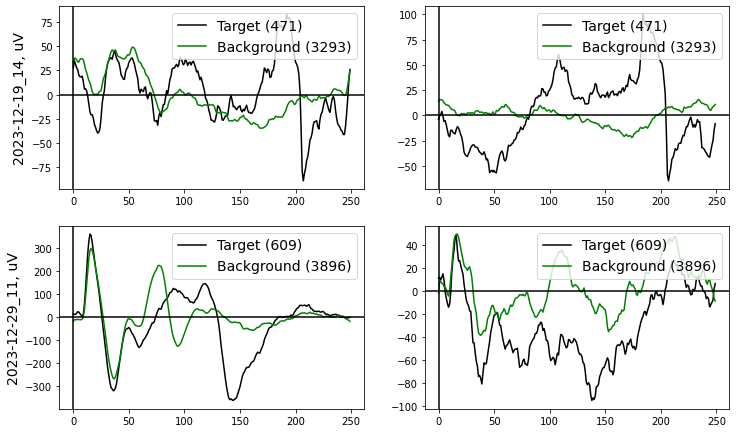

In [35]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed'  # change it to your path

sessions = [
   '57_SIT_2023-12-19_14-15-26',
   '57_SIT_2023-12-29_11-06-26'
]

all_areas = ['A1', 'PPC']
cols = len(all_areas)
rows = len(selected)
speed_thresh = 0.04  # m/s

fig = plt.figure(figsize=(6*cols, 4*rows))

for i, session in enumerate(sessions):
    animal     = session.split('_')[0]
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    aeps_file  = os.path.join(source, animal, session, 'AEPs.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    
    # getting AEPs
    aeps = {}
    with h5py.File(aeps_file, 'r') as f:
        for area in all_areas:
            if not area in f:
                continue
            ds_name = [ds for ds in f[area]][0]
            aeps[area] = np.array(f[area][ds_name])
    with h5py.File(meta_file, 'r') as f:
        events = np.array(f['processed']['sound_events'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
    
    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_run_ev = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]  # define speed filter here
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    
    # plotting
    idxs_A = idxs_tgt_ev
    idxs_B = idxs_bgr_ev
    labels = ['Target', 'Background']
    for j, area in enumerate(areas):
        ax = fig.add_subplot(rows, cols, 2*i+1+j)
        aeps_A_mean = aeps[area][idxs_A].mean(axis=0)
        aeps_B_mean = aeps[area][idxs_B].mean(axis=0)
        
        ax.plot(aeps_A_mean, color='black', label="%s (%d)" % (labels[0], len(idxs_A)))
        ax.plot(aeps_B_mean, color='green', label="%s (%d)" % (labels[1], len(idxs_B)))
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.legend(loc='upper right', prop={'size': 14})
        if j == 0:
            ax.set_ylabel('%s, uV' % session[-19:-6], fontsize=14)

#fig.savefig('AEPs_avgs_%s.pdf' % animal)